In [1]:
# load necessary packages and view available data
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
%matplotlib inline

Using TensorFlow backend.


In [2]:
sns.set()
print(os.listdir("./Data"))

['desktop.ini', 'test_FD001.txt', 'train_FD001.txt']


In [3]:
# the files did not contain headers. Here we create labels.
target_var = ['Target_Remaining_Useful_Life']
index_columns_names =  ["UnitNumber","Cycle"]
op_settings_columns = ["Op_Setting_"+str(i) for i in range(1,4)]
sensor_columns =["Sensor_"+str(i) for i in range(1,22)]
column_names = index_columns_names + op_settings_columns + sensor_columns
print(column_names)

['UnitNumber', 'Cycle', 'Op_Setting_1', 'Op_Setting_2', 'Op_Setting_3', 'Sensor_1', 'Sensor_2', 'Sensor_3', 'Sensor_4', 'Sensor_5', 'Sensor_6', 'Sensor_7', 'Sensor_8', 'Sensor_9', 'Sensor_10', 'Sensor_11', 'Sensor_12', 'Sensor_13', 'Sensor_14', 'Sensor_15', 'Sensor_16', 'Sensor_17', 'Sensor_18', 'Sensor_19', 'Sensor_20', 'Sensor_21']


In [4]:
# load data
train= pd.read_csv('./Data/train_FD001.txt', sep=" ", header=None)
test = pd.read_csv('./Data/test_FD001.txt', sep=" ", header=None)
print("train shape: ", train.shape, "test shape: ", test.shape)

train shape:  (20631, 28) test shape:  (13096, 28)


In [5]:
# drop NULL columns
train.drop(train.columns[[26, 27]], axis=1, inplace=True)
test.drop(test.columns[[26, 27]], axis=1, inplace=True)

In [6]:
print("train shape: ", train.shape, "test shape: ", test.shape)

train shape:  (20631, 26) test shape:  (13096, 26)


In [7]:
# name columns
train.columns = [column_names]
test.columns = [column_names]

In [8]:
#print(train.head(3))
#print(train.iloc[200:].head(5))
train.iloc[:].head(5)
#train[train['UnitNumber'] == 1].head(5)

,UnitNumber,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,...,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [9]:
test.iloc[:].head(5)
#test[test['UnitNumber'] == 1].head(5)

,UnitNumber,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,...,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [10]:
# fix multiindex label by using correct columns list
train = pd.DataFrame(train.iloc[0:].values, columns = column_names)

In [11]:
# this section calculates Remaining Useful Life (RUL) in T-minus notation for the training data
# find the last cycle per unit number
max_cycle = train.groupby('UnitNumber')['Cycle'].max().reset_index()

In [12]:
max_cycle.columns = ['UnitNumber', 'MaxOfCycle']

In [13]:
# merge the max cycle back into the original frame
train_merged = train.merge(max_cycle, left_on='UnitNumber', right_on='UnitNumber', how='inner')
train_merged

,UnitNumber,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,...,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21,MaxOfCycle
0,1.0,1.0,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392.0,2388.0,100.0,39.06,23.4190,192.0
1,1.0,2.0,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392.0,2388.0,100.0,39.00,23.4236,192.0
2,1.0,3.0,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390.0,2388.0,100.0,38.95,23.3442,192.0
3,1.0,4.0,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392.0,2388.0,100.0,38.88,23.3739,192.0
4,1.0,5.0,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393.0,2388.0,100.0,38.90,23.4044,192.0
5,1.0,6.0,-0.0043,-0.0001,100.0,518.67,642.10,1584.47,1398.37,14.62,...,2388.03,8132.85,8.4108,0.03,391.0,2388.0,100.0,38.98,23.3669,192.0
6,1.0,7.0,0.0010,0.0001,100.0,518.67,642.48,1592.32,1397.77,14.62,...,2388.03,8132.32,8.3974,0.03,392.0,2388.0,100.0,39.10,23.3774,192.0
7,1.0,8.0,-0.0034,0.0003,100.0,518.67,642.56,1582.96,1400.97,14.62,...,2388.03,8131.07,8.4076,0.03,391.0,2388.0,100.0,38.97,23.3106,192.0
8,1.0,9.0,0.0008,0.0001,100.0,518.67,642.12,1590.98,1394.80,14.62,...,2388.05,8125.69,8.3728,0.03,392.0,2388.0,100.0,39.05,23.4066,192.0
9,1.0,10.0,-0.0033,0.0001,100.0,518.67,641.71,1591.24,1400.46,14.62,...,2388.06,8129.38,8.4286,0.03,393.0,2388.0,100.0,38.95,23.4694,192.0


In [14]:
# calculate RUL for each row
Target_Remaining_Useful_Life = train_merged["MaxOfCycle"] - train_merged["Cycle"]
train_with_target = train_merged["Target_Remaining_Useful_Life"] = Target_Remaining_Useful_Life
# remove unnecessary column
train_with_target = train_merged.drop("MaxOfCycle", axis=1)
print (train_with_target[train_with_target['UnitNumber'] == 1].head(5))

   UnitNumber  Cycle  Op_Setting_1  Op_Setting_2  Op_Setting_3  Sensor_1  \
0         1.0    1.0       -0.0007       -0.0004         100.0    518.67   
1         1.0    2.0        0.0019       -0.0003         100.0    518.67   
2         1.0    3.0       -0.0043        0.0003         100.0    518.67   
3         1.0    4.0        0.0007        0.0000         100.0    518.67   
4         1.0    5.0       -0.0019       -0.0002         100.0    518.67   

   Sensor_2  Sensor_3  Sensor_4  Sensor_5  ...  Sensor_13  Sensor_14  \
0    641.82   1589.70   1400.60     14.62  ...    2388.02    8138.62   
1    642.15   1591.82   1403.14     14.62  ...    2388.07    8131.49   
2    642.35   1587.99   1404.20     14.62  ...    2388.03    8133.23   
3    642.35   1582.79   1401.87     14.62  ...    2388.08    8133.83   
4    642.37   1582.85   1406.22     14.62  ...    2388.04    8133.80   

   Sensor_15  Sensor_16  Sensor_17  Sensor_18  Sensor_19  Sensor_20  \
0     8.4195       0.03      392.0     

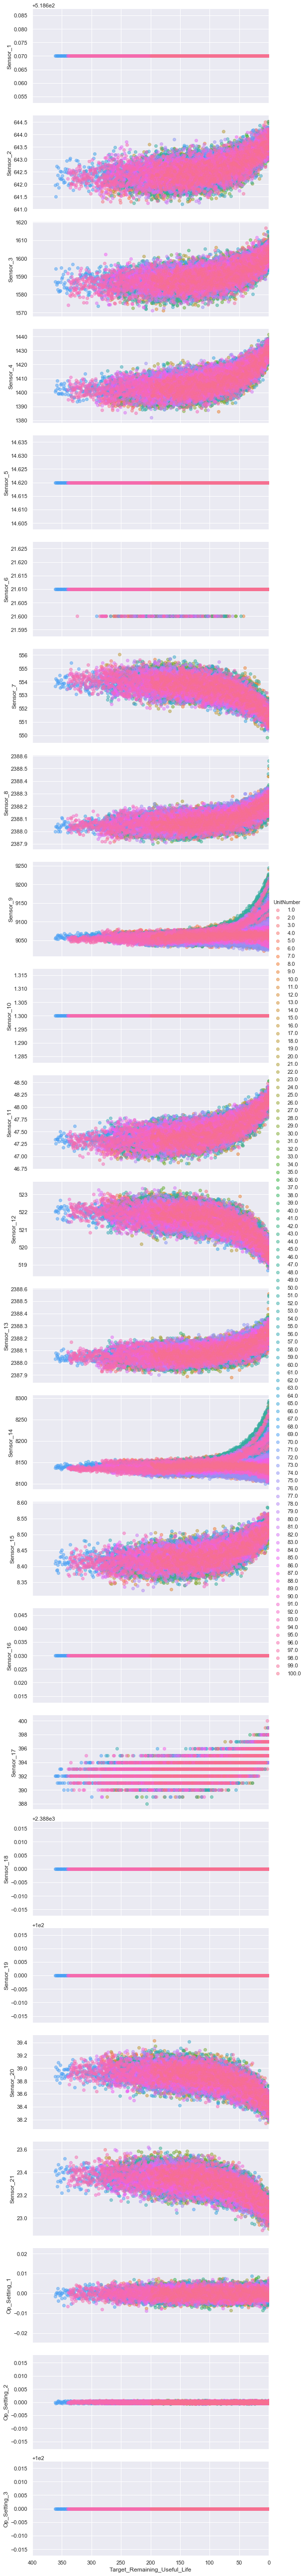

In [15]:
# use seaborn to visualize features to target (RUL)
explore = sns.PairGrid(data=train_with_target.query('UnitNumber < 101') ,
                 x_vars=target_var,
                 y_vars=sensor_columns + op_settings_columns,
                 hue="UnitNumber", height=3, aspect=2.5)
explore = explore.map(plt.scatter, alpha=0.5)
explore = explore.set(xlim=(400,0))
explore = explore.add_legend()

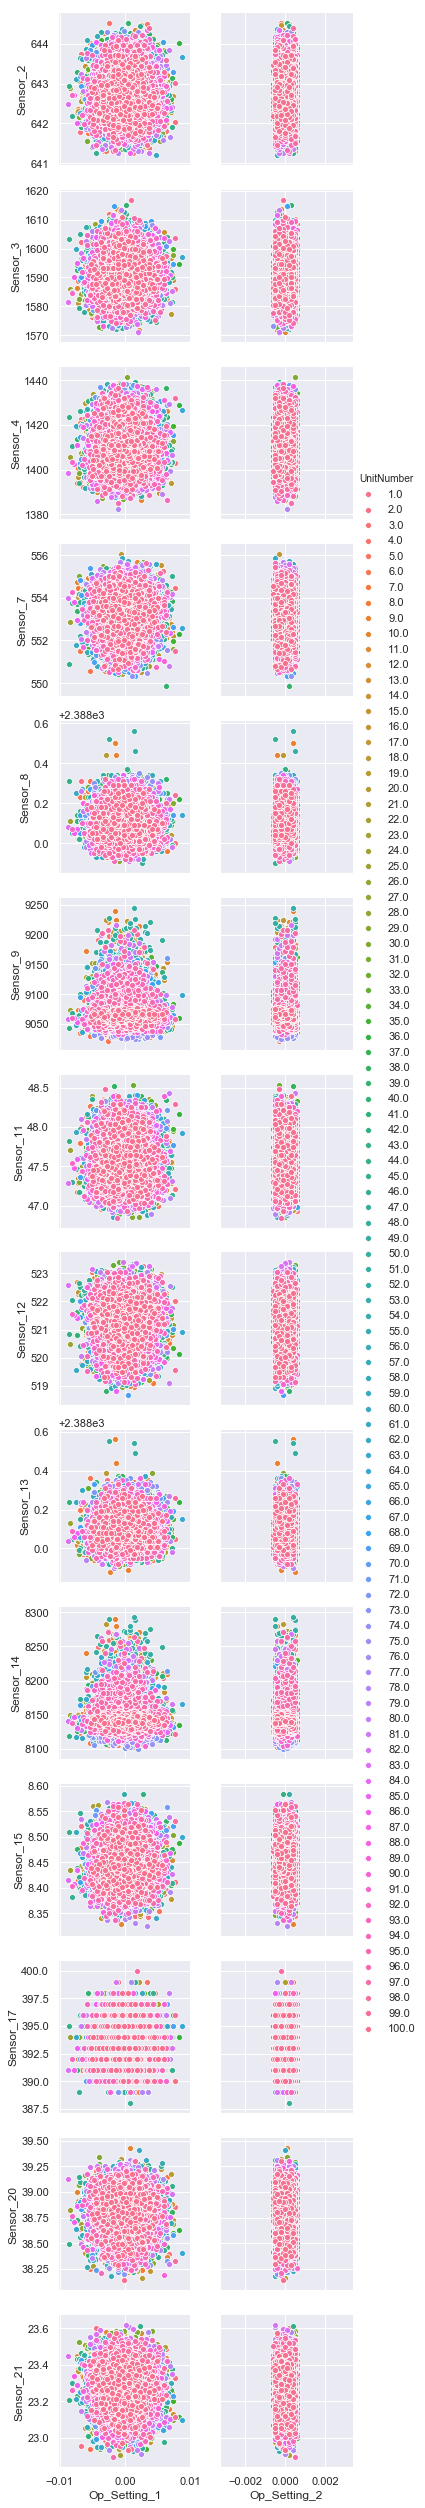

In [16]:
# operational setting 3 is stable, let's visualize op setting 1 and 2 against some of the most active sensors
g = sns.pairplot(data=train_with_target.query('UnitNumber < 101'),
                 x_vars=["Op_Setting_1","Op_Setting_2"],
                 y_vars=["Sensor_2", "Sensor_3", "Sensor_4", "Sensor_7", "Sensor_8", "Sensor_9", "Sensor_11", "Sensor_12", "Sensor_13", "Sensor_14", "Sensor_15", "Sensor_17", "Sensor_20", "Sensor_21"],
                 hue="UnitNumber", aspect=1)

In [17]:
# now it's time to clear out target leakage
print(train_with_target.shape)
leakage_to_drop = ['UnitNumber', 'Cycle', 'Op_Setting_1', 'Op_Setting_2', 'Op_Setting_3']  
train_no_leakage = train_with_target.drop(leakage_to_drop, axis = 1)
print(train_no_leakage.shape)
# set up features and target variable 
y = train_no_leakage['Target_Remaining_Useful_Life']
X = train_no_leakage.drop(['Target_Remaining_Useful_Life'], axis = 1)

(20631, 27)
(20631, 22)


In [18]:
# I like to use a simple random forest to determine some of the most important/meaningful features. Can be used as feature selection
# create an exhuastive random forest (200 trees up to 15 levels deep)
from sklearn import ensemble
rf = ensemble.RandomForestRegressor()
single_rf = ensemble.RandomForestRegressor(n_estimators = 200, max_depth = 15)
single_rf.fit(X, y)
y_pred = single_rf.predict(X)
print("complete")

complete


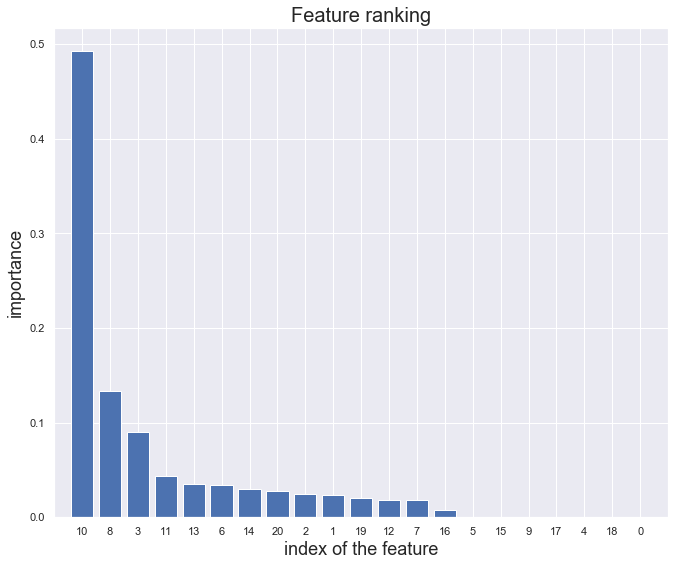

Sensor_11    0.492426
Sensor_9     0.133867
Sensor_4     0.089949
Sensor_12    0.043875
Sensor_14    0.034736
Sensor_7     0.034570
Sensor_15    0.029593
Sensor_21    0.027773
Sensor_3     0.024642
Sensor_2     0.023434
Sensor_20    0.020235
Sensor_13    0.018656
Sensor_8     0.017758
Sensor_17    0.007979
Sensor_6     0.000509
Sensor_16    0.000000
Sensor_10    0.000000
Sensor_18    0.000000
Sensor_5     0.000000
Sensor_19    0.000000
Sensor_1     0.000000
dtype: float64


In [19]:
# graph feature importance
import matplotlib.pyplot as plt
importances = single_rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns    
f, ax = plt.subplots(figsize=(11, 9))
plt.title("Feature ranking", fontsize = 20)
plt.bar(range(X.shape[1]), importances[indices], color="b", align="center")
plt.xticks(range(X.shape[1]), indices) #feature_names, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.ylabel("importance", fontsize = 18)
plt.xlabel("index of the feature", fontsize = 18)
plt.show()
# list feature importance
important_features = pd.Series(data=single_rf.feature_importances_,index=X.columns)
important_features.sort_values(ascending=False,inplace=True)
print(important_features.head(21))

In [20]:
# based on the graphs as well as random forest feature importance, I will exclude sensors without much valuable information
print(train_no_leakage.shape)
vars_to_drop = ["Sensor_"+str(i) for i in [5, 15, 9, 17, 4, 18]]
train_final = train_no_leakage.drop(vars_to_drop, axis = 1)
print(train_final.shape)

(20631, 22)
(20631, 16)


In [21]:
# identify categorical and numeric fields
from sklearn import preprocessing
categorical = train_final.select_dtypes(include=['object'])
numeric = train_final.select_dtypes(exclude=['object'])
print(categorical.columns.values)
# create dummy variables (if any categorical fields)
for name, values in categorical.items():
    print(name)
    dummies = pd.get_dummies(values.str.strip(), prefix = name, dummy_na=True)
    numeric = pd.concat([numeric, dummies], axis=1)
# imputation (if any NULL values)
for name in numeric:
    print(name)
    if pd.isnull(numeric[name]).sum() > 0:
        numeric["%s_mi" % (name)] = pd.isnull(numeric[name])
        median = numeric[name].median()
        numeric[name] = numeric[name].apply(lambda x: median if pd.isnull(x) else x)
y = numeric['Target_Remaining_Useful_Life']
X = numeric.drop(['Target_Remaining_Useful_Life'], axis = 1)

[]
Sensor_1
Sensor_2
Sensor_3
Sensor_6
Sensor_7
Sensor_8
Sensor_10
Sensor_11
Sensor_12
Sensor_13
Sensor_14
Sensor_16
Sensor_19
Sensor_20
Sensor_21
Target_Remaining_Useful_Life


In [22]:
# random forest regression
# create holdout
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
# choose the model
from sklearn.ensemble import RandomForestRegressor
rf = ensemble.RandomForestRegressor()
# set up 5-fold cross-validation
from sklearn import model_selection
cv = model_selection.KFold(5)
# pipeline standardization and model
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', rf) ])
# tune the model
my_min_samples_leaf = [2, 10, 25, 50, 100]
my_max_depth = [7, 8, 9, 10, 11, 12]
# run the model using gridsearch, select the model with best search
from sklearn.model_selection import GridSearchCV
optimized_rf = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid =dict(model__min_samples_leaf = my_min_samples_leaf, model__max_depth = my_max_depth)
                            , scoring = 'neg_mean_squared_error'
                            , verbose = 1
                            , n_jobs = -1
                           )
optimized_rf.fit(X_train, y_train)
# show the best model estimators
print(optimized_rf.best_estimator_)
# evaluate metrics on holdout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = optimized_rf.predict(X_test)
print("Random Forest Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("Random Forest Mean Absolute Error: ", mean_absolute_error(y_test, y_pred))
print("Random Forest r-squared: ", r2_score(y_test, y_pred))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   41.5s finished
C:\Users\Talha\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=25, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])
Random Forest Mean Squared Error:  1807.7626703410717
Random Forest Mean Absolute Error:  30.30778198914985
Random Forest r-squared:  0.6175002057461438


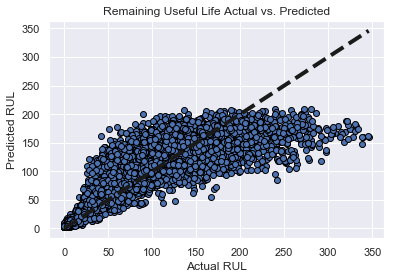

In [23]:
# plot actual vs predicted Remaining Useful Life for the best model (Random Forest Regression model)
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual RUL')
ax.set_ylabel('Predicted RUL')
ax.set_title('Remaining Useful Life Actual vs. Predicted')
plt.show()

In [24]:
# Support Vector Machines
# create holdout
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
# choose the model
from sklearn import svm
from sklearn.svm import SVR
svm = svm.SVR()
# set up 5-fold cross-validation
from sklearn import model_selection
cv = model_selection.KFold(5)
# pipeline standardization and model
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', svm) ])
# tune the model
my_C = [1]
my_epsilon = [.05, .1, .15]
# run the model using gridsearch, select the model with best search
from sklearn.model_selection import GridSearchCV
optimized_svm = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid =dict(model__C = my_C, model__epsilon = my_epsilon)
                            , scoring = 'neg_mean_squared_error'
                            , verbose = 1
                            , n_jobs = -1
                           )
optimized_svm.fit(X_train, y_train)
# show the best model estimators
print(optimized_svm.best_estimator_)
# evaluate metrics on holdout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = optimized_svm.predict(X_test)
print("SVM Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("SVM Mean Absolute Error: ", mean_absolute_error(y_test, y_pred))
print("SVM r-squared: ", r2_score(y_test, y_pred))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.6min finished
C:\Users\Talha\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.05,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))])
SVM Mean Squared Error:  1858.154949223506
SVM Mean Absolute Error:  30.319590062171176
SVM r-squared:  0.6068378347276752


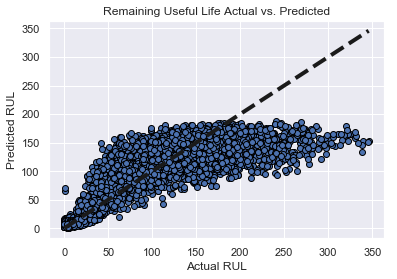

In [25]:
# plot actual vs predicted Remaining Useful Life for the best model (SVM model)
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual RUL')
ax.set_ylabel('Predicted RUL')
ax.set_title('Remaining Useful Life Actual vs. Predicted')
plt.show()

In [26]:
# now let's look at turning this into a classification sol -> can we confidently identify when an asset within its last 15 cycles?
# generate label columns for training data
cycles = 15
train_no_leakage['Target_15_Cycles'] = np.where(train_no_leakage['Target_Remaining_Useful_Life'] <= cycles, 1, 0 )
train_no_leakage.tail(5)

,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,Sensor_6,Sensor_7,Sensor_8,Sensor_9,Sensor_10,...,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21,Target_Remaining_Useful_Life,Target_15_Cycles
20626,518.67,643.49,1597.98,1428.63,14.62,21.61,551.43,2388.19,9065.52,1.3,...,8137.60,8.4956,0.03,397.0,2388.0,100.0,38.49,22.9735,4.0,1
20627,518.67,643.54,1604.50,1433.58,14.62,21.61,550.86,2388.23,9065.11,1.3,...,8136.50,8.5139,0.03,395.0,2388.0,100.0,38.30,23.1594,3.0,1
20628,518.67,643.42,1602.46,1428.18,14.62,21.61,550.94,2388.24,9065.90,1.3,...,8141.05,8.5646,0.03,398.0,2388.0,100.0,38.44,22.9333,2.0,1
20629,518.67,643.23,1605.26,1426.53,14.62,21.61,550.68,2388.25,9073.72,1.3,...,8139.29,8.5389,0.03,395.0,2388.0,100.0,38.29,23.0640,1.0,1
20630,518.67,643.85,1600.38,1432.14,14.62,21.61,550.79,2388.26,9061.48,1.3,...,8137.33,8.5036,0.03,396.0,2388.0,100.0,38.37,23.0522,0.0,1


In [27]:
# based on the graphs as well as random forest feature importance, I will exclude sensors without much valuable information
print(train_no_leakage.shape)
vars_to_drop = ["Sensor_"+str(i) for i in [5, 15, 9, 17, 4, 18]]
target_to_drop = ['Target_Remaining_Useful_Life']
train_final = train_no_leakage.drop(vars_to_drop, axis = 1)
#train_final = train_no_leakage.drop(target_to_drop, axis = 1)
train_final = train_final.drop(target_to_drop, axis = 1)
train_final.tail()

(20631, 23)


,Sensor_1,Sensor_2,Sensor_3,Sensor_6,Sensor_7,Sensor_8,Sensor_10,Sensor_11,Sensor_12,Sensor_13,Sensor_14,Sensor_16,Sensor_19,Sensor_20,Sensor_21,Target_15_Cycles
20626,518.67,643.49,1597.98,21.61,551.43,2388.19,1.3,48.07,519.49,2388.26,8137.60,0.03,100.0,38.49,22.9735,1
20627,518.67,643.54,1604.50,21.61,550.86,2388.23,1.3,48.04,519.68,2388.22,8136.50,0.03,100.0,38.30,23.1594,1
20628,518.67,643.42,1602.46,21.61,550.94,2388.24,1.3,48.09,520.01,2388.24,8141.05,0.03,100.0,38.44,22.9333,1
20629,518.67,643.23,1605.26,21.61,550.68,2388.25,1.3,48.39,519.67,2388.23,8139.29,0.03,100.0,38.29,23.0640,1
20630,518.67,643.85,1600.38,21.61,550.79,2388.26,1.3,48.20,519.30,2388.26,8137.33,0.03,100.0,38.37,23.0522,1


In [28]:
# identify categorical and numeric fields
from sklearn import preprocessing
categorical = train_final.select_dtypes(include=['object'])
numeric = train_final.select_dtypes(exclude=['object'])
print(categorical.columns.values)
# create dummy variables (if any categorical fields)
for name, values in categorical.items():
    print(name)
    dummies = pd.get_dummies(values.str.strip(), prefix = name, dummy_na=True)
    numeric = pd.concat([numeric, dummies], axis=1)
# imputation (if any NULL values)
for name in numeric:
    print(name)
    if pd.isnull(numeric[name]).sum() > 0:
        numeric["%s_mi" % (name)] = pd.isnull(numeric[name])
        median = numeric[name].median()
        numeric[name] = numeric[name].apply(lambda x: median if pd.isnull(x) else x)
y = numeric['Target_15_Cycles']
X = numeric.drop(['Target_15_Cycles'], axis = 1)

[]
Sensor_1
Sensor_2
Sensor_3
Sensor_6
Sensor_7
Sensor_8
Sensor_10
Sensor_11
Sensor_12
Sensor_13
Sensor_14
Sensor_16
Sensor_19
Sensor_20
Sensor_21
Target_15_Cycles


In [29]:
# random forest Classifier
# create holdout
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
# choose the model
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
rf = ensemble.RandomForestClassifier()
# set up 5-fold cross-validation
from sklearn import model_selection
cv = model_selection.KFold(5)
# pipeline standardization and model
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', rf) ])
# tune the model
my_min_samples_leaf = [2, 25, 50]
my_max_depth = [8, 9, 10, 12]
# run the model using gridsearch, select the model with best search
from sklearn.model_selection import GridSearchCV
optimized_rf = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid =dict(model__min_samples_leaf = my_min_samples_leaf, model__max_depth = my_max_depth)
                            , scoring = 'roc_auc'
                            , verbose = 1
                            , n_jobs = -1
                           )
optimized_rf.fit(X_train, y_train)
# show the best model estimators
y_pred_proba = optimized_rf.predict_proba(X_test)[:, 1]
y_pred = optimized_rf.predict(X_test)
print(optimized_rf.best_estimator_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    6.4s finished
C:\Users\Talha\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
 ...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])


Confusion Matrix:
[[3789   53]
 [  42  243]]
Random Forest Accuracy: 97.7%
Random Forest Precision: 82.1%
Random Forest Recall: 85.3%
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3842
           1       0.82      0.85      0.84       285

   micro avg       0.98      0.98      0.98      4127
   macro avg       0.90      0.92      0.91      4127
weighted avg       0.98      0.98      0.98      4127



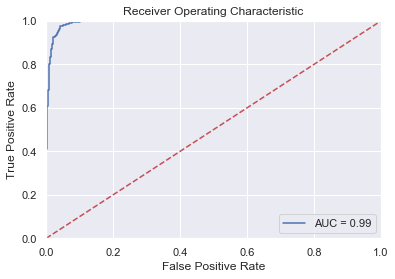

In [30]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
from sklearn.metrics import classification_report
print("Random Forest Accuracy: "+"{:.1%}".format(accuracy_score(y_test, y_pred)));
print("Random Forest Precision: "+"{:.1%}".format(precision_score(y_test, y_pred)));
print("Random Forest Recall: "+"{:.1%}".format(recall_score(y_test, y_pred)));
print("Classification Report:")
print(classification_report(y_test, y_pred))
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_proba)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [31]:
# start evaluation with a new set of data - test_FD001.txt.
# fix multiindex label by using correct columns list
evaluation_data = pd.DataFrame(test.iloc[0:].values, columns = column_names)
X_evaluation = evaluation_data.drop(leakage_to_drop, axis = 1)
X_evaluation

,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,Sensor_6,Sensor_7,Sensor_8,Sensor_9,Sensor_10,...,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21
0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,...,521.72,2388.03,8125.55,8.4052,0.03,392.0,2388.0,100.0,38.86,23.3735
1,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,...,522.16,2388.06,8139.62,8.3803,0.03,393.0,2388.0,100.0,39.02,23.3916
2,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,...,521.97,2388.03,8130.10,8.4441,0.03,393.0,2388.0,100.0,39.08,23.4166
3,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,...,521.38,2388.05,8132.90,8.3917,0.03,391.0,2388.0,100.0,39.00,23.3737
4,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,...,522.15,2388.03,8129.54,8.4031,0.03,390.0,2388.0,100.0,38.99,23.4130
5,518.67,642.11,1579.12,1395.13,14.62,21.61,554.22,2388.00,9050.96,1.3,...,521.92,2388.08,8127.46,8.4238,0.03,392.0,2388.0,100.0,38.91,23.3467
6,518.67,642.11,1583.34,1404.84,14.62,21.61,553.89,2388.05,9051.39,1.3,...,522.01,2388.06,8134.97,8.3914,0.03,391.0,2388.0,100.0,38.85,23.3952
7,518.67,642.54,1580.89,1400.89,14.62,21.61,553.59,2388.05,9052.86,1.3,...,522.09,2388.06,8125.93,8.4213,0.03,393.0,2388.0,100.0,39.05,23.3224
8,518.67,641.88,1593.29,1412.28,14.62,21.61,554.49,2388.06,9048.55,1.3,...,522.03,2388.05,8134.15,8.4353,0.03,391.0,2388.0,100.0,39.10,23.4521
9,518.67,642.07,1585.25,1398.64,14.62,21.61,554.28,2388.04,9051.95,1.3,...,522.00,2388.06,8134.08,8.4093,0.03,391.0,2388.0,100.0,38.87,23.3820


In [32]:
# based on the graphs as well as random forest feature importance, I will exclude sensors without much valuable information
evaluation_vars_to_drop = ["Sensor_"+str(i) for i in [5, 15, 9, 17, 4, 18]]
X_evaluation_final = X_evaluation.drop(evaluation_vars_to_drop, axis = 1)

print('few sensors to drop which are not helpful')
print(X_evaluation_final.tail())

few sensors to drop which are not helpful
       Sensor_1  Sensor_2  Sensor_3  Sensor_6  Sensor_7  Sensor_8  Sensor_10  \
13091    518.67    643.24   1599.45     21.61    553.41   2388.02        1.3   
13092    518.67    643.22   1595.69     21.61    553.22   2388.05        1.3   
13093    518.67    643.44   1593.15     21.61    553.04   2388.11        1.3   
13094    518.67    643.26   1594.99     21.61    553.37   2388.07        1.3   
13095    518.67    642.95   1601.62     21.61    552.48   2388.06        1.3   

       Sensor_11  Sensor_12  Sensor_13  Sensor_14  Sensor_16  Sensor_19  \
13091      47.69     520.69    2388.00    8213.28       0.03      100.0   
13092      47.60     521.05    2388.09    8210.85       0.03      100.0   
13093      47.57     521.18    2388.04    8217.24       0.03      100.0   
13094      47.61     521.33    2388.08    8220.48       0.03      100.0   
13095      47.80     521.07    2388.05    8214.64       0.03      100.0   

       Sensor_20  Sensor_2

In [33]:
y_evaluation_pred = optimized_rf.predict(X_evaluation_final)
y_evaluation_pred

array([0, 0, 0, ..., 0, 0, 0])

In [34]:
y_evaluation_pred = pd.DataFrame(y_evaluation_pred)
y_evaluation_pred.columns = ['Evaluation_Prediction_RUL']
y_evaluation_pred

,Evaluation_Prediction_RUL
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [35]:
evaluation_data['Evaluation_Prediction_RUL'] = y_evaluation_pred
evaluation_data

,UnitNumber,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,...,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21,Evaluation_Prediction_RUL
0,1.0,1.0,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392.0,2388.0,100.0,38.86,23.3735,0
1,1.0,2.0,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393.0,2388.0,100.0,39.02,23.3916,0
2,1.0,3.0,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393.0,2388.0,100.0,39.08,23.4166,0
3,1.0,4.0,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391.0,2388.0,100.0,39.00,23.3737,0
4,1.0,5.0,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390.0,2388.0,100.0,38.99,23.4130,0
5,1.0,6.0,0.0012,0.0003,100.0,518.67,642.11,1579.12,1395.13,14.62,...,2388.08,8127.46,8.4238,0.03,392.0,2388.0,100.0,38.91,23.3467,0
6,1.0,7.0,-0.0000,0.0002,100.0,518.67,642.11,1583.34,1404.84,14.62,...,2388.06,8134.97,8.3914,0.03,391.0,2388.0,100.0,38.85,23.3952,0
7,1.0,8.0,0.0006,-0.0000,100.0,518.67,642.54,1580.89,1400.89,14.62,...,2388.06,8125.93,8.4213,0.03,393.0,2388.0,100.0,39.05,23.3224,0
8,1.0,9.0,-0.0036,0.0000,100.0,518.67,641.88,1593.29,1412.28,14.62,...,2388.05,8134.15,8.4353,0.03,391.0,2388.0,100.0,39.10,23.4521,0
9,1.0,10.0,-0.0025,-0.0001,100.0,518.67,642.07,1585.25,1398.64,14.62,...,2388.06,8134.08,8.4093,0.03,391.0,2388.0,100.0,38.87,23.3820,0


In [36]:
RUL_data = evaluation_data.loc[evaluation_data['Evaluation_Prediction_RUL'] == 1]
RUL_data

,UnitNumber,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,...,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21,Evaluation_Prediction_RUL
2432,20.0,182.0,-0.0008,-0.0005,100.0,518.67,643.54,1589.93,1421.09,14.62,...,2388.22,8139.41,8.4677,0.03,396.0,2388.0,100.0,38.66,23.1186,1
2433,20.0,183.0,0.0008,0.0003,100.0,518.67,643.33,1604.18,1423.09,14.62,...,2388.23,8137.63,8.5354,0.03,397.0,2388.0,100.0,38.51,23.1460,1
3863,31.0,190.0,0.0031,-0.0004,100.0,518.67,643.35,1597.79,1421.66,14.62,...,2388.16,8156.54,8.4771,0.03,395.0,2388.0,100.0,38.38,23.1424,1
3864,31.0,191.0,0.0010,-0.0004,100.0,518.67,643.29,1597.31,1413.64,14.62,...,2388.15,8156.70,8.4773,0.03,395.0,2388.0,100.0,38.73,22.9354,1
3865,31.0,192.0,0.0047,-0.0000,100.0,518.67,643.86,1597.63,1433.36,14.62,...,2388.18,8161.00,8.5274,0.03,394.0,2388.0,100.0,38.69,23.0716,1
3866,31.0,193.0,-0.0002,0.0001,100.0,518.67,643.72,1597.09,1429.89,14.62,...,2388.20,8157.21,8.4807,0.03,396.0,2388.0,100.0,38.44,23.1582,1
3867,31.0,194.0,0.0020,-0.0002,100.0,518.67,643.30,1593.45,1426.21,14.62,...,2388.19,8156.40,8.4803,0.03,395.0,2388.0,100.0,38.52,23.0864,1
3868,31.0,195.0,0.0031,-0.0004,100.0,518.67,643.57,1603.82,1426.44,14.62,...,2388.20,8151.14,8.4715,0.03,396.0,2388.0,100.0,38.49,23.1562,1
3869,31.0,196.0,-0.0005,0.0001,100.0,518.67,643.31,1598.19,1420.66,14.62,...,2388.22,8157.84,8.5015,0.03,395.0,2388.0,100.0,38.53,23.1105,1
4262,34.0,198.0,-0.0040,0.0003,100.0,518.67,643.40,1591.44,1418.85,14.62,...,2388.27,8127.26,8.4980,0.03,397.0,2388.0,100.0,38.59,23.2135,1


Conclusion:
Above mentioned 56 Machine units are having less than or equal to 15 remaining useful life cycles and these machines will be 
failed very soon. 